### LLM Initialize

In [1]:
from langchain_ollama.llms import OllamaLLM
from langchain_ollama.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

llm = ChatOllama(model="llama3.2:3b-instruct-q8_0", temperature=0, streaming=True)
llm

ChatOllama(model='llama3.2:3b-instruct-q8_0', temperature=0.0)

### Tool Initialize

In [2]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: str, b: str) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: str, b: str) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtracts a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b




#### Run this to set llm with tools

In [3]:
# Augment the LLM with tools
tools = [add, multiply, divide, subtract]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
llm_with_tools
# result = tools[0].invoke({"a":"2", "b":"4"})
# result

RunnableBinding(bound=ChatOllama(model='llama3.2:3b-instruct-q8_0', temperature=0.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'string'}, 'b': {'type': 'string'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'string'}, 'b': {'type': 'string'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'subtract', 'description': 'Subtracts a and

### LangGraph


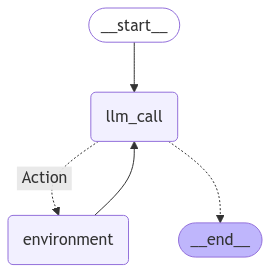

LLMCALL
{'messages': [HumanMessage(content='Add 5 and 4. Subtract 1 to the result, and then divide it by 2.', additional_kwargs={}, response_metadata={}, id='aaf89529-29d2-4197-9208-0bf57d6e5020')]}
Ho
{'messages': [HumanMessage(content='Add 5 and 4. Subtract 1 to the result, and then divide it by 2.', additional_kwargs={}, response_metadata={}, id='aaf89529-29d2-4197-9208-0bf57d6e5020'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b-instruct-q8_0', 'created_at': '2025-02-11T13:50:02.723050146Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5279467247, 'load_duration': 24325985, 'prompt_eval_count': 443, 'prompt_eval_duration': 2560000000, 'eval_count': 22, 'eval_duration': 2691000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-7b198fc5-19c4-44ff-bf28-3b488137cebc-0', tool_calls=[{'name': 'subtract', 'args': {'a': 9, 'b': 2}, 'id': '9d965052-d199-4ba6-bb0b-efa013e25b55', 'type': 'tool_call'}]

In [4]:
from langgraph.graph import MessagesState
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""
    print("LLMCALL")
    print(state)
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs. If the problem is complex that requires multiple steps, do it one at a time."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""
    print("TOOL CALL")
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    print("Ho")
    print(state)
    print("state ^^^")
    messages = state["messages"]
    print("messages vvv\n")
    for msg in messages:
        print(f"{type(msg).__name__}: {msg}\n")


    last_message = messages[-1]
    print("last message", type(last_message), last_message)
    # print(last_message.tool_calls)
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 5 and 4. Subtract 1 to the result, and then divide it by 2.")]
messages = agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()
print("last line sa ubos ani")
print(messages)
print("\nLast message is:", messages["messages"][-1])

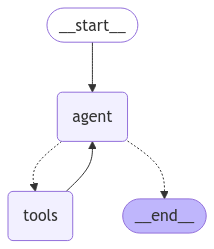

================================ Human Message =================================

Do this step by step. Add 5 and 4. Subtract 1 to the result, and then divide it by 2. Use all tools needed. Explain your answer
================================== Ai Message ==================================
Tool Calls:
  add (14f437e0-51c8-40e1-90f6-d10e7519a5c9)
 Call ID: 14f437e0-51c8-40e1-90f6-d10e7519a5c9
  Args:
    a: 5
    b: 4
  subtract (1afc8aa4-1ecf-4983-b0bd-03701c381f2e)
 Call ID: 1afc8aa4-1ecf-4983-b0bd-03701c381f2e
  Args:
    a: 9
    b: 1
  divide (df7922f6-5c17-4d8e-b56e-2d9bb6c3ee5b)
 Call ID: df7922f6-5c17-4d8e-b56e-2d9bb6c3ee5b
  Args:
    a: 8
    b: 2
================================= Tool Message =================================
Name: add

Error: 2 validation errors for add
a
  Input should be a valid string [type=string_type, input_value=5, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type
b
  Input should be a valid string [type=s

In [4]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langgraph.graph import MessagesState
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Do this step by step. Add 5 and 4. Subtract 1 to the result, and then divide it by 2. Use all tools needed. Explain your answer")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()